# Examples Sheet 2 - PDS

## Pre-Amble

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as integ
import matplotlib.gridspec as gs

plt.style.use("/home/jhughes2712/projects/coursework/mphildis-coursework/mphil.mplstyle")

## Question 1: Marginalising & Conditioning

Just to check my understanding I have implemented the joint distribution in matrix-vector form, but this is likely more efficiently implemented using, say, scipy.stats.

In [20]:
def MVN(x, m, v):
    x = x.reshape((-1,1))
    return (((2 * np.pi)**(x.shape[0]) * np.linalg.det(v))**(-0.5)) * np.exp(- 0.5 * (x - m).T @ np.linalg.inv(v) @ (x - m))[0]

Plot the Joint Distribution

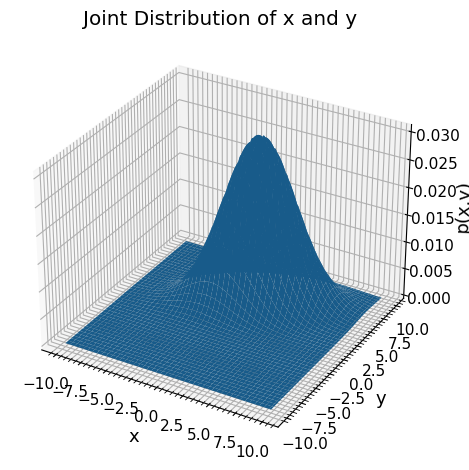

In [21]:
ax = plt.figure().add_subplot(projection='3d')

Mu = np.array([[1], [4]])
V = np.array([[9, 3], [3, 4]])
MVN_XY = lambda x: MVN(x, m=Mu, v=V)

X = np.linspace(-10, 10, 401)
Y = np.linspace(-10, 10, 401)
X, Y = np.meshgrid(X, Y)

W = np.vstack([X.flatten(), Y.flatten()])
Z = np.apply_along_axis(MVN_XY, arr=W, axis=0).reshape(X.shape)

surf = ax.plot_surface(X, Y, Z)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("p(x,y)")
ax.set_title("Joint Distribution of x and y")

plt.show()

We integrate in the following way to get the marginal probabilities:
$$f(X) = \int_{-\infty}^{+\infty}f(X,Y)dY$$

In [22]:
MVN_X = np.vectorize(lambda x: integ.quad(lambda y: MVN_XY(np.array([[x], [y]])), -np.inf, np.inf)[0])
MVN_Y = np.vectorize(lambda y: integ.quad(lambda x: MVN_XY(np.array([[x], [y]])), -np.inf, np.inf)[0])

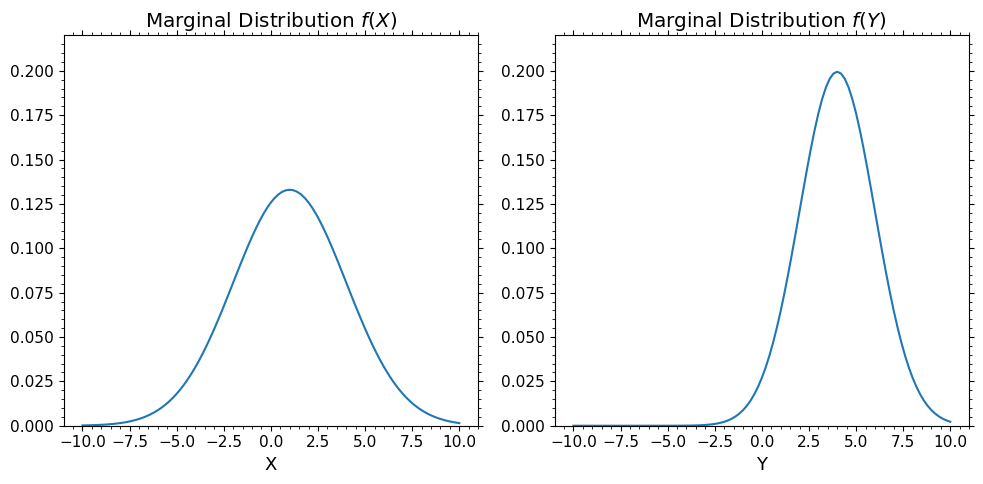

In [53]:
fig = plt.figure(figsize=(10,5))
grid = gs.GridSpec(1, 2)

W = np.linspace(-10,10,101)

marginal_X = MVN_X(W)
ax1 = plt.subplot(grid[0,0])
ax1.plot(W, marginal_X)
ax1.set(xlabel="X", ylim=(0,0.22), title="Marginal Distribution $f(X)$")

marginal_Y = MVN_Y(W)
ax2 = plt.subplot(grid[0,1])
ax2.plot(W, marginal_Y)
ax2.set(xlabel="Y", ylim=(0,0.22), title="Marginal Distribution $f(Y)$")

plt.show()

To get the marginal probabilities we compute:
$$f(X|Y) =\frac{f(X,Y)}{f(Y)}$$

In [38]:
MVN_XcondY = lambda x,y : MVN_XY(np.array([[x],[y]])) / MVN_Y(y)
MVN_YcondX = lambda y,x : MVN_XY(np.array([[x],[y]])) / MVN_X(x)

Below we plot the a few examples of both conditional probabilities, with dotted orange plots showing the respective marginal distributions.

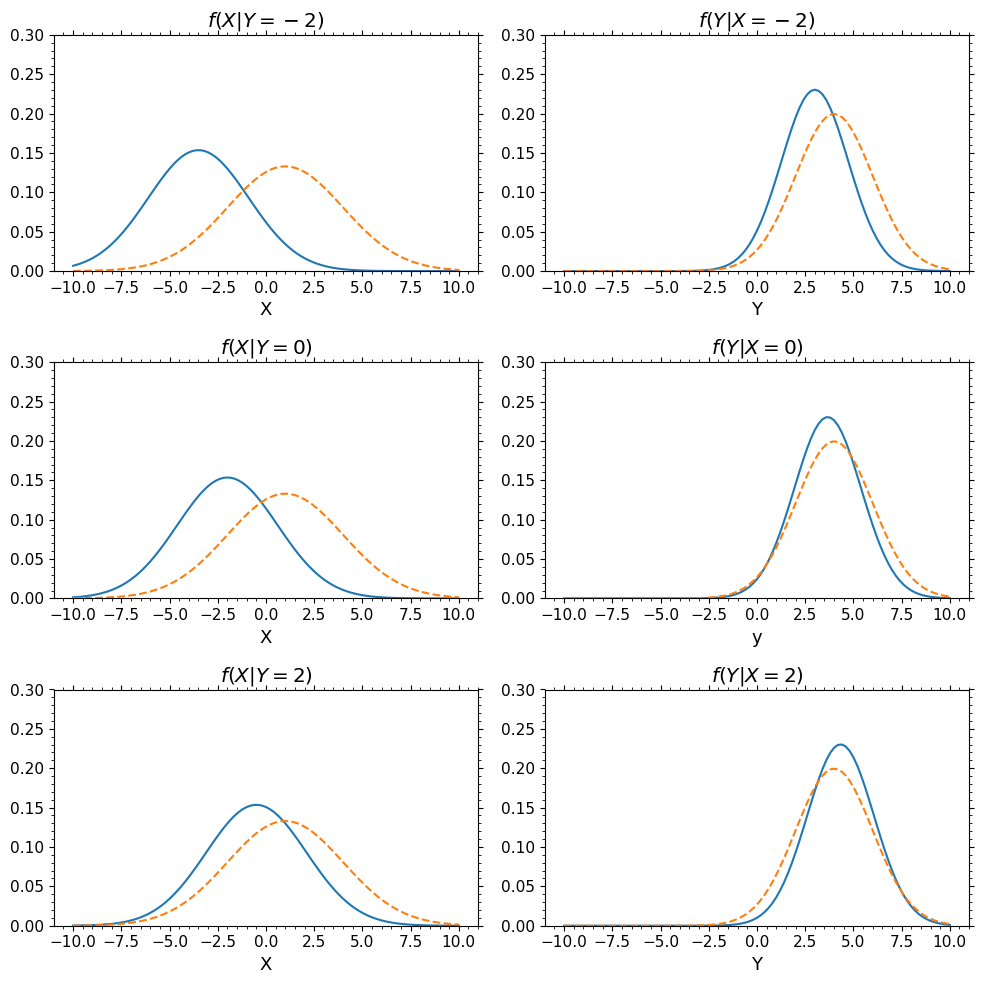

In [85]:
fig = plt.figure(figsize=(10,10))
grid = gs.GridSpec(3, 2)

W = np.linspace(-10,10,101)

ax1 = plt.subplot(grid[0,0])
ax1.plot(W, np.vectorize(lambda x: MVN_XcondY(x,-2))(W))
ax1.plot(W, marginal_X, linestyle="--")
ax1.set(xlabel="X", ylim=(0,0.3), title="$f(X|Y=-2)$")

ax2 = plt.subplot(grid[1,0])
ax2.plot(W, np.vectorize(lambda x: MVN_XcondY(x,0))(W))
ax2.plot(W, marginal_X, linestyle="--")
ax2.set(xlabel="X", ylim=(0,0.3), title="$f(X|Y=0)$")

ax3 = plt.subplot(grid[2,0])
ax3.plot(W, np.vectorize(lambda x: MVN_XcondY(x,2))(W))
ax3.plot(W, marginal_X, linestyle="--")
ax3.set(xlabel="X", ylim=(0,0.3), title="$f(X|Y=2)$")

ax4 = plt.subplot(grid[0,1])
ax4.plot(W, np.vectorize(lambda x: MVN_YcondX(x,-2))(W))
ax4.plot(W, marginal_Y, linestyle="--")
ax4.set(xlabel="Y", ylim=(0,0.3), title="$f(Y|X=-2)$")

ax5 = plt.subplot(grid[1,1])
ax5.plot(W, np.vectorize(lambda x: MVN_YcondX(x,0))(W))
ax5.plot(W, marginal_Y, linestyle="--")
ax5.set(xlabel="Y", ylim=(0,0.3), title="$f(Y|X=0)$")

ax6 = plt.subplot(grid[2,1])
ax6.plot(W, np.vectorize(lambda x: MVN_YcondX(x,2))(W))
ax6.plot(W, marginal_Y, linestyle="--")
ax6.set(xlabel="Y", ylim=(0,0.3), title="$f(Y|X=2)$")

plt.show()

## Question 4: Rejection Sampling

In [56]:
np.random.uniform(0,1)

0.7919843962402219

In [83]:
def rej_sample(pdf, n, lim, max_jobs=1e6):
    """Generates a random sample from any given distribution using rejection sampling.

    Args:
        pdf (function): returns the value of the pdf of the distribution given a float input. Need not be normalised, just nonnegative.
        n (int): number of samples to realise.
        lim (tuple): gives the support of the pdf in the form (a,b).
    """
    a, b = lim
    x_vals = np.linspace(a,b,1001)
    y_max = np.max(np.vectorize(pdf)(x_vals))
    sample = []
    jobs = 0
    while len(sample) < n and jobs < max_jobs:
        x = np.random.uniform(a, b)
        y = np.random.uniform(0, y_max)
        if y < pdf(x):
            sample.append(x)
        jobs += 1
    return sample, jobs

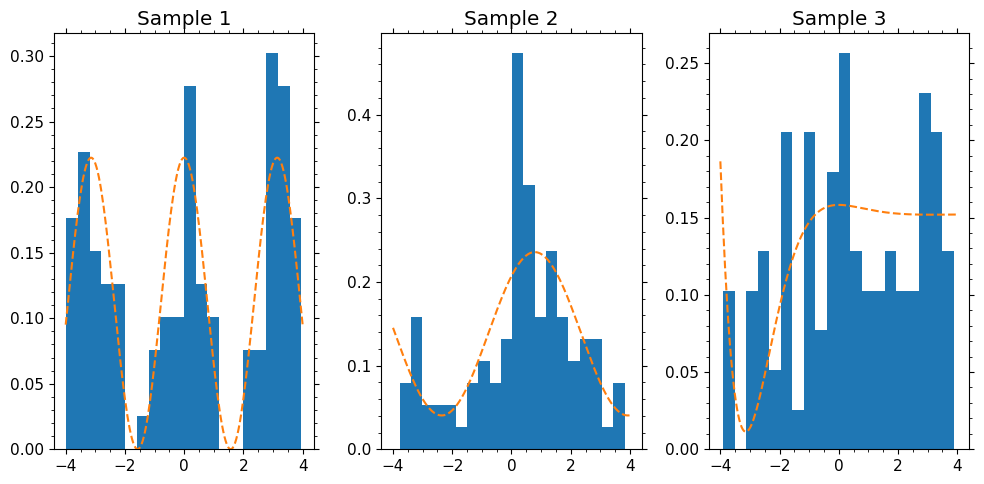

In [86]:
fig = plt.figure(figsize=(10, 5))
grid = gs.GridSpec(1, 3)

W = np.linspace(-4,4,201)

f1 = lambda x: np.cos(x)**2
f2 = lambda x: np.sin(x)+np.cos(x)+2
f3 = lambda x: (np.sin(x)+np.cos(x)) / (np.exp(x)) + 25

pdf1 = lambda x: f1(x) / integ.quad(f1, -4, 4)[0]
pdf2 = lambda x: f2(x) / integ.quad(f2, -4, 4)[0]
pdf3 = lambda x: f3(x) / integ.quad(f3, -4, 4)[0]

ax1 = plt.subplot(grid[0,0])
ax1.hist(rej_sample(pdf1, 100, (-4,4))[0], bins=20, density=True)
ax1.plot(W, pdf1(W), linestyle="--")
ax1.set(title="Sample 1")

ax2 = plt.subplot(grid[0,1])
ax2.hist(rej_sample(pdf2, 100, (-4,4))[0], bins=20, density=True)
ax2.plot(W, pdf2(W), linestyle="--")
ax2.set(title="Sample 2")

ax3 = plt.subplot(grid[0,2])
ax3.hist(rej_sample(pdf3, 100, (-4,4))[0], bins=20, density=True)
ax3.plot(W, pdf3(W), linestyle="--")
ax3.set(title="Sample 3")

plt.show()

In [96]:
sample, jobs = rej_sample(gaussian_st, 1000, (-1,1))

In [98]:
jobs

1153

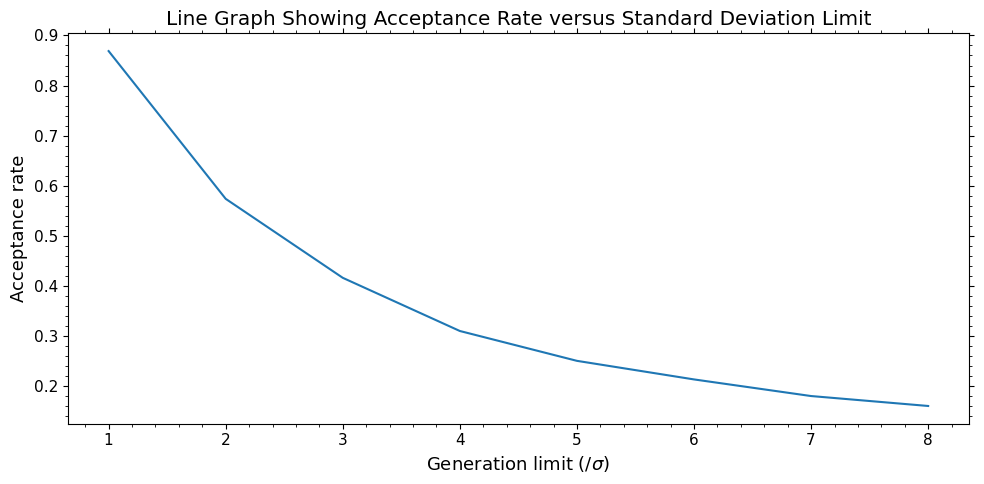

In [102]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes()

gaussian_st = lambda x: (2 * np.pi)**(-0.5) * np.exp(- 0.5 * (x**2))

accept_rate = []
for sg in range(1,9):
    sample, jobs = rej_sample(gaussian_st, 1000, (-sg,+sg))
    accept_rate.append(len(sample) / jobs)
ax.plot(range(1,9), accept_rate)
ax.set(xlabel="Generation limit ($/\sigma$)", ylabel="Acceptance rate",
title="Line Graph Showing Acceptance Rate versus Standard Deviation Limit")

plt.show()

This makes sense because the true rate generating at 8 deviations should be approximately, based on the sampling method,
$$(16\times \frac{1}{\sqrt{2\pi}})^{-1} = 0.156$$
This uses the fact that the area under the standard gaussian function in the interval $(-8,8)$ is very close to 1.